# Data modelling comparison - Kirchooff and FD data

### Author: M.Ravasi

This notebook contains a comparison between Kirchooff modelling using the below equation and FD modelling (with constant-density, acoustic wave equation):

$$
d(\mathbf{x_r}, \mathbf{x_s}, t) = \tilde{w}(t) * \int_V \frac{2 } {v(\mathbf{x})}
a(\mathbf{x}, \mathbf{x_s}) a(\mathbf{x}, \mathbf{x_r})
e^{j \omega (t(\mathbf{x_r}, \mathbf{x}) +
t(\mathbf{x}, \mathbf{x_s}))} m(\mathbf{x}) \,\mathrm{d}\mathbf{x}
$$

where $m(\mathbf{x})$ represents the angle averaged reflectivity at every location in the subsurface, $a$ is the amplitude and $t$ is the traveltime.

In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import devito

from scipy.signal import filtfilt
from scipy.sparse.linalg import lsqr
from numba import jit

from pylops import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.kirchhoff import Kirchhoff
from pylops.waveeqprocessing.twoway import AcousticWave2D

from fdmod import fdmodelling, refl_angle

devito.configuration['log-level'] = 'ERROR'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Layered

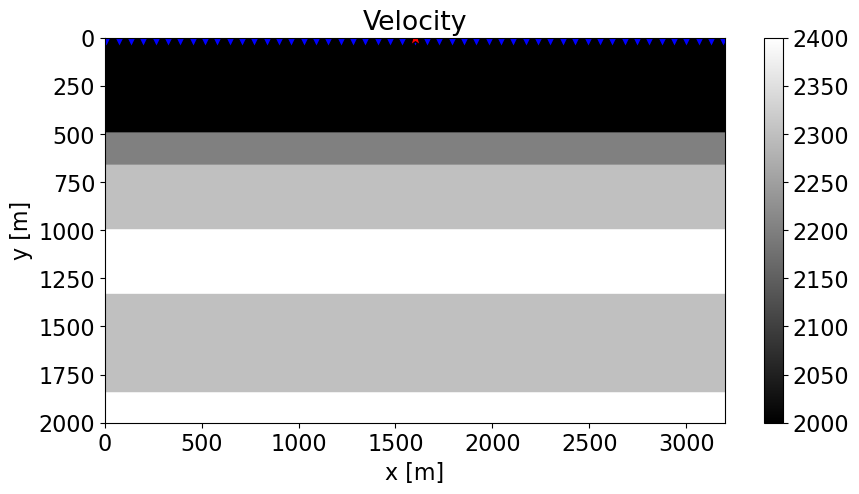

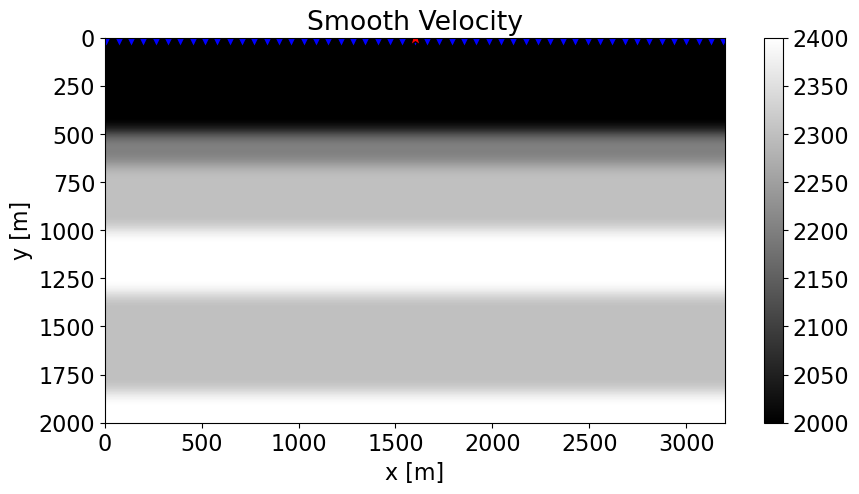

In [13]:
#Velocity
nx, nz = 401, 251
dx, dz = 8, 8
x, z = np.arange(nx)*dx, np.arange(nz)*dz

v0 = 2000
vel_true = v0 * np.ones((nx, nz))
vel_true[:, nz//4:] = 2200
vel_true[:, nz//3:] = 2300
vel_true[:, nz//2:] = 2400
vel_true[:, 2*nz//3:] = 2300
vel_true[:, -20:] = 2400

nsmooth = 10
vel_sm = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_true, axis=1)

# Receivers
nr = 51
rx = np.linspace(dx, (nx-2)*dx, nr)
rz = 0*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

# Sources
ns = 1
sx = x[nx//2] * np.ones(ns)
sz = 0*np.ones(ns)
sources = np.vstack((sx, sz))

plt.figure(figsize=(10,5))
im = plt.imshow(vel_true.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(vel_sm.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Smooth Velocity')
plt.ylim(z[-1], z[0]);

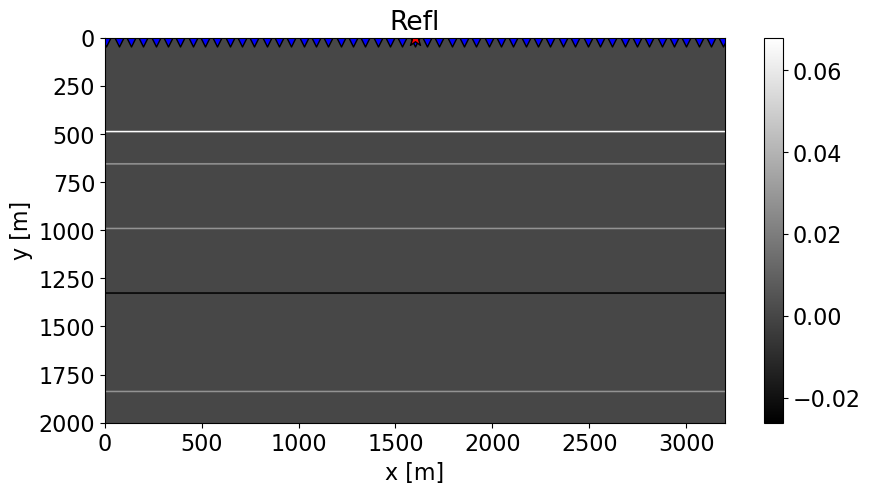

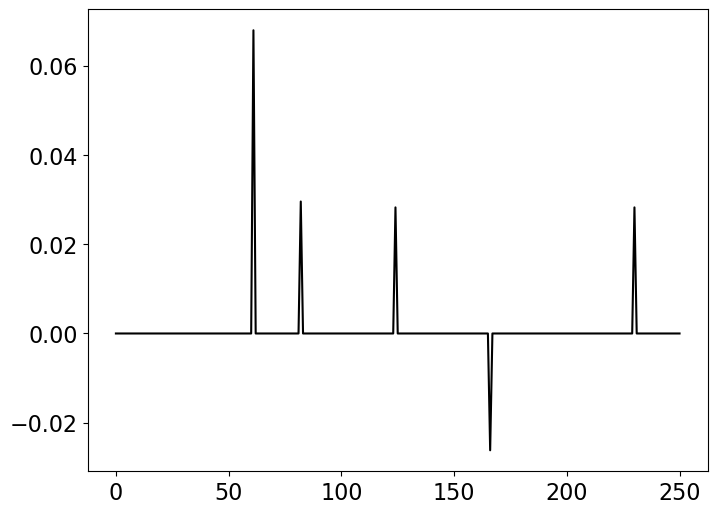

In [14]:
# Compute full angle and averaged reflectivity
nthetas = 51
thetas0 = np.linspace(-60, 60, nthetas)

refls, refl_av = refl_angle(thetas0, vel_true)

plt.figure(figsize=(10,5))
im = plt.imshow(refl_av.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Refl')
plt.ylim(z[-1], z[0]);

plt.figure()
plt.plot(refl_av[nx//2], 'k');

In [15]:
# Kirchhoff modelling
nt = 601
dt = 0.004
f0 = 15
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=f0)

kop = Kirchhoff(z, x, t, sources, recs, vel_true, wav, wavc, mode='eikonal', 
                dynamic=True, wavfilter=False, aperture=None, angleaperture=200, engine='numba')
kop.angle_recs = kop.angle_srcs.copy() # done as a quick and dirty way to remove the cos(theta) weighting term in modelling

dottest(kop, verb=True)

d = kop * refl_av.ravel()
d = d.reshape(ns, nr, nt)

Dot test passed, v^H(Opu)=-0.009367840178549604 - u^H(Op^Hv)=-0.009367840178549589


In [16]:
# Comparison with FD
tn = 4000 # Total simulation time

v0_ = v0 * np.ones((nx, nz))
v0_[-1, -1] = vel_true.max()
d_fd, u_fd, dt_fd = fdmodelling(vel_true, dx, dz, dt, sx, sz, rx, rz, tn, f0, v0, 0, nt)
d0_fd, u0_fd, dt0_fd = fdmodelling(v0_, dx, dz, dt, sx, sz, rx, rz, tn, f0, v0, 0, nt)
d0_fd[:, 251:] = 0
d_fd = d_fd - d0_fd

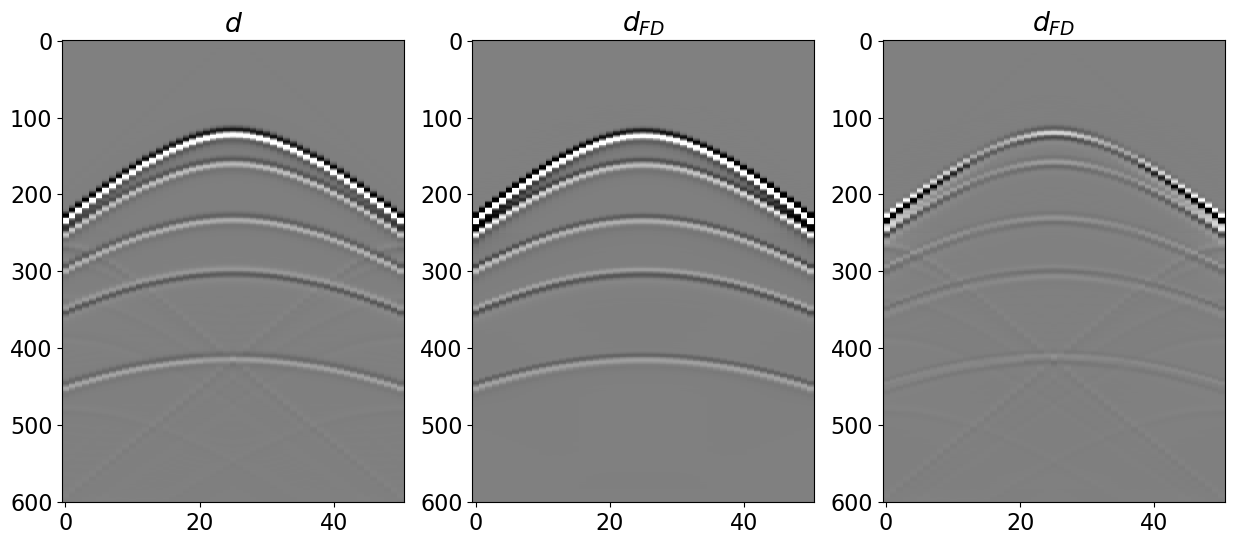

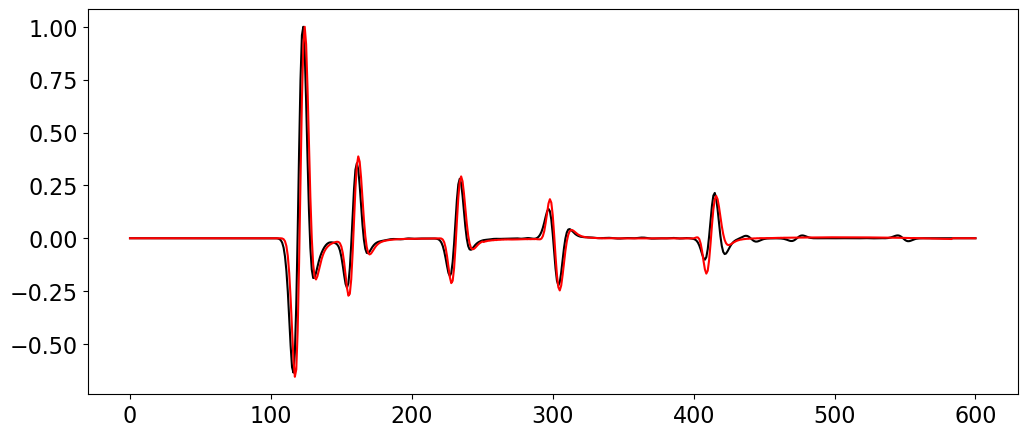

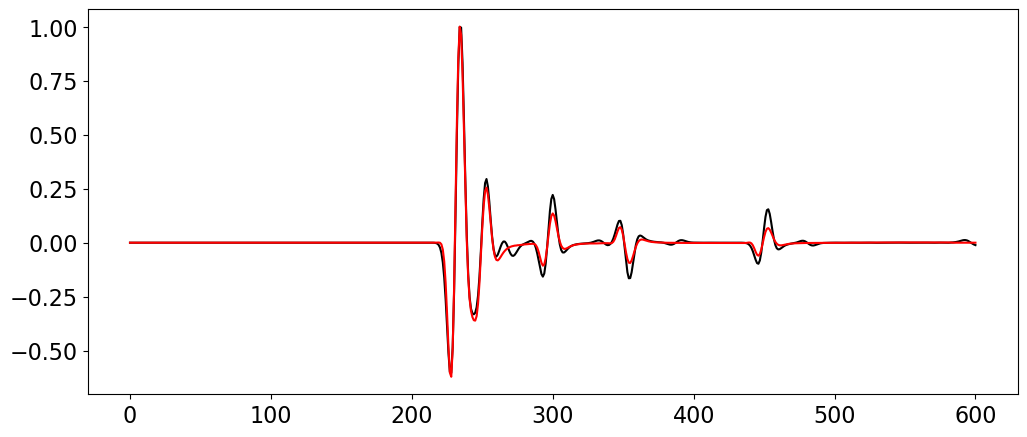

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d[0, :, :].T / np.max(d[ns//2, nr//2, :].T), cmap='gray', interpolation='none', vmin=-8e-1, vmax=8e-1)
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(d_fd[:, :nt].T / np.max(d_fd[nr//2, :nt].T), cmap='gray', interpolation='none', vmin=-8e-1, vmax=8e-1)
axs[1].set_title(r'$d_{FD}$')
axs[1].axis('tight')
axs[2].imshow(d[0, :, :].T / np.max(d[ns//2, nr//2, :].T) - d_fd[:, :nt].T / np.max(d_fd[nr//2, :nt].T), 
              cmap='gray', interpolation='none', vmin=-8e-1, vmax=8e-1)
axs[2].set_title(r'$d_{FD}$')
axs[2].axis('tight')

plt.figure(figsize=(12, 5))
plt.plot(d[0, nr//2, :].T / np.max(d[ns//2, nr//2, :].T), 'k')
plt.plot(d_fd[nr//2, :nt].T / np.max(d_fd[nr//2, :nt].T), 'r');

plt.figure(figsize=(12, 5))
plt.plot(d[0, 0, :].T / np.max(d[0, 0, :].T), 'k')
plt.plot(d_fd[0, :nt].T / np.max(d_fd[0, :nt].T), 'r');

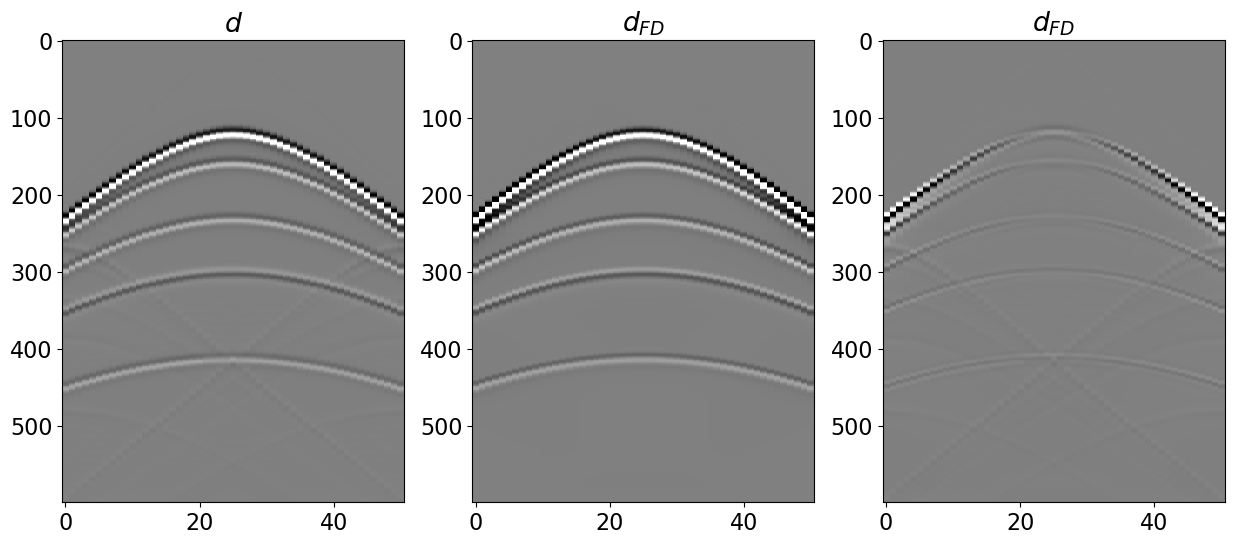

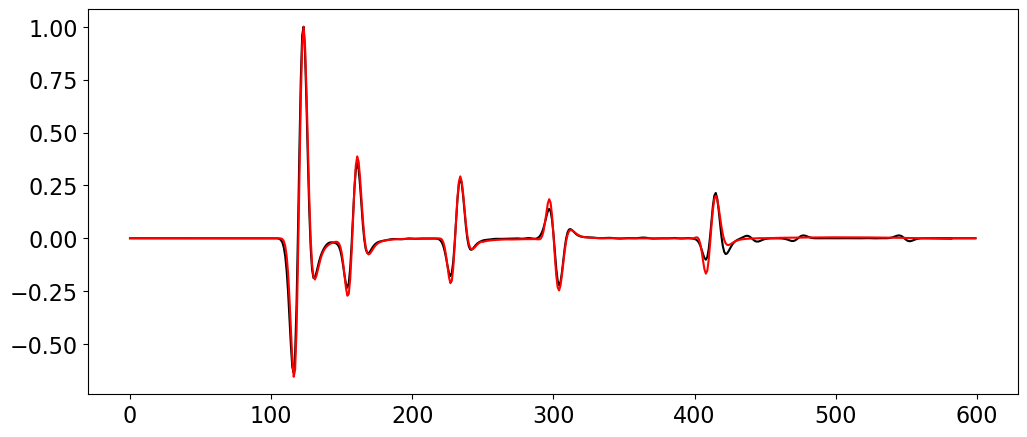

In [21]:
# Add little shift to account for small errors in ET vs eikonal/analytical
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d[0, :, :nt-1].T / np.max(d[ns//2, nr//2, :].T), cmap='gray', interpolation='none', vmin=-8e-1, vmax=8e-1)
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(d_fd[:, 1:].T / np.max(d_fd[nr//2, :nt].T), cmap='gray', interpolation='none', vmin=-8e-1, vmax=8e-1)
axs[1].set_title(r'$d_{FD}$')
axs[1].axis('tight')
axs[2].imshow(d[0, :, :nt-1].T / np.max(d[ns//2, nr//2, :].T) - d_fd[:, 1:].T / np.max(d_fd[nr//2, :nt].T), 
              cmap='gray', interpolation='none', vmin=-8e-1, vmax=8e-1)
axs[2].set_title(r'$d_{FD}$')
axs[2].axis('tight')

plt.figure(figsize=(12, 5))
plt.plot(d[0, nr//2, :nt-1].T / np.max(d[ns//2, nr//2, :].T), 'k')
plt.plot(d_fd[nr//2, 1:].T / np.max(d_fd[nr//2, :nt].T), 'r');

## Marmousi

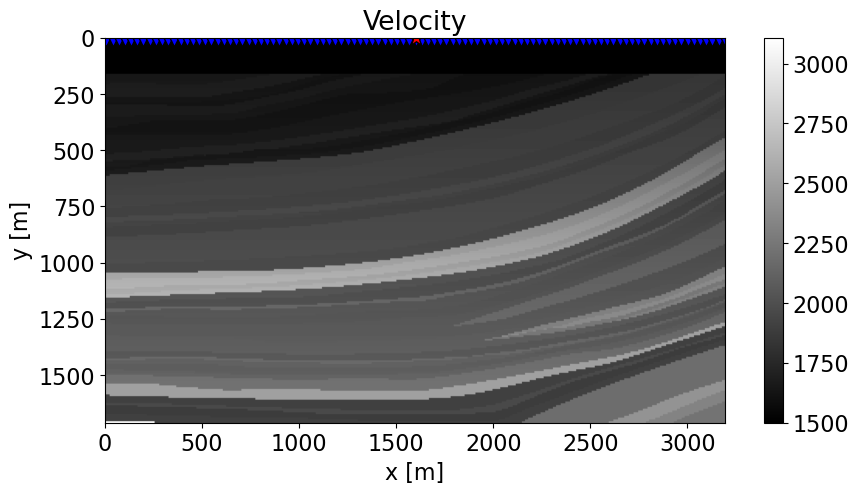

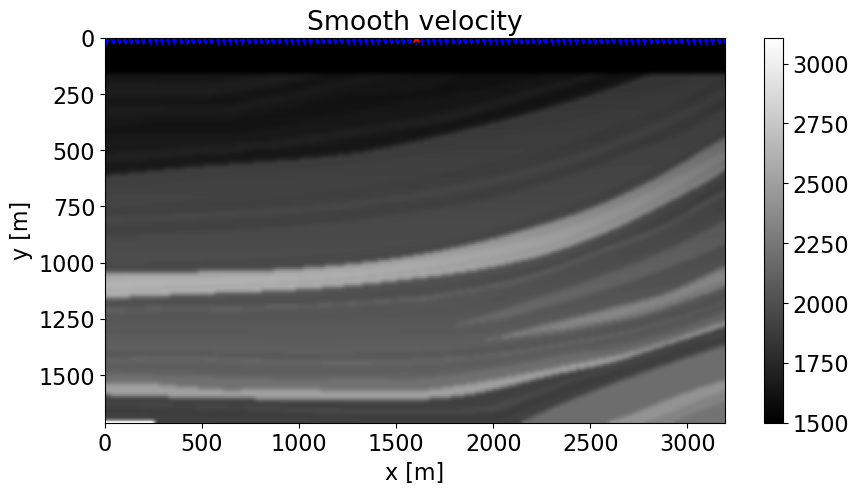

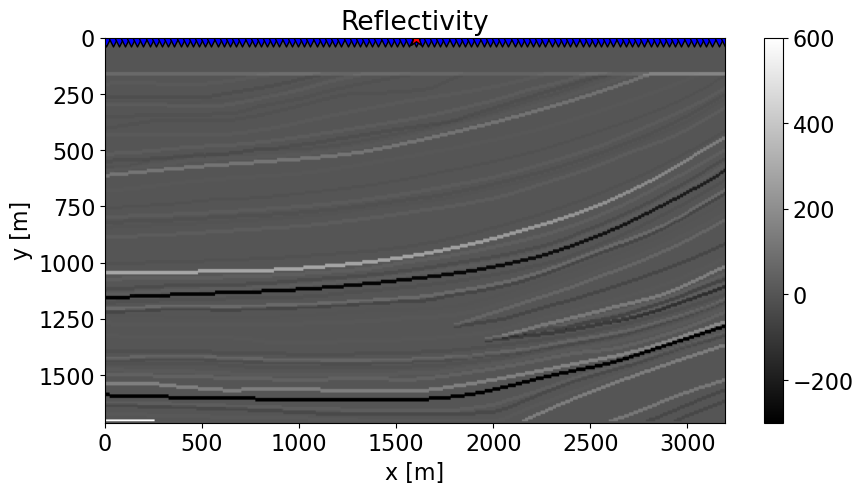

In [7]:
#Velocity
inputfile='../data/avo/poststack_model.npz'

model = np.load(inputfile)
x, z, vel_true = model['x'] - model['x'][0], model['z'] - model['z'][0], 1000*model['model'].T
x, z, vel_true = x[::2], z[::2], (vel_true[::2, ::2] - vel_true.min()) / 2.5 + 1600
nx, nz = len(x), len(z)
dx, dz = x[1]-x[0], z[1]-z[0]

# Pad water
v0 = 1500
vel_true = np.pad(vel_true, ((0,0),(20,0)), constant_values=1500)

# Crop
vel_true = vel_true[:, :nz-60]
z = z[:nz-60]
nz = len(z)

# Impedance
rho = 1.
ip_true = rho * vel_true

# Reflectivity
Dop = FirstDerivative(dims=(nx, nz), axis=1)
refl = Dop * ip_true

# Smooth velocity
nsmooth = 3
vel_sm = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_true, axis=0)
vel_sm = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_sm, axis=1)

# Receivers
nr = 101
rx = np.linspace(dx, (nx-1)*dx, nr)
rz = 0*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

# Sources
ns = 1
sx = x[nx//2] * np.ones(ns)
sz = 0*np.ones(ns)
sources = np.vstack((sx, sz))

plt.figure(figsize=(10,5))
im = plt.imshow(vel_true.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(vel_sm.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0], recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Smooth velocity')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(refl.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Reflectivity')
plt.ylim(z[-1], z[0]);

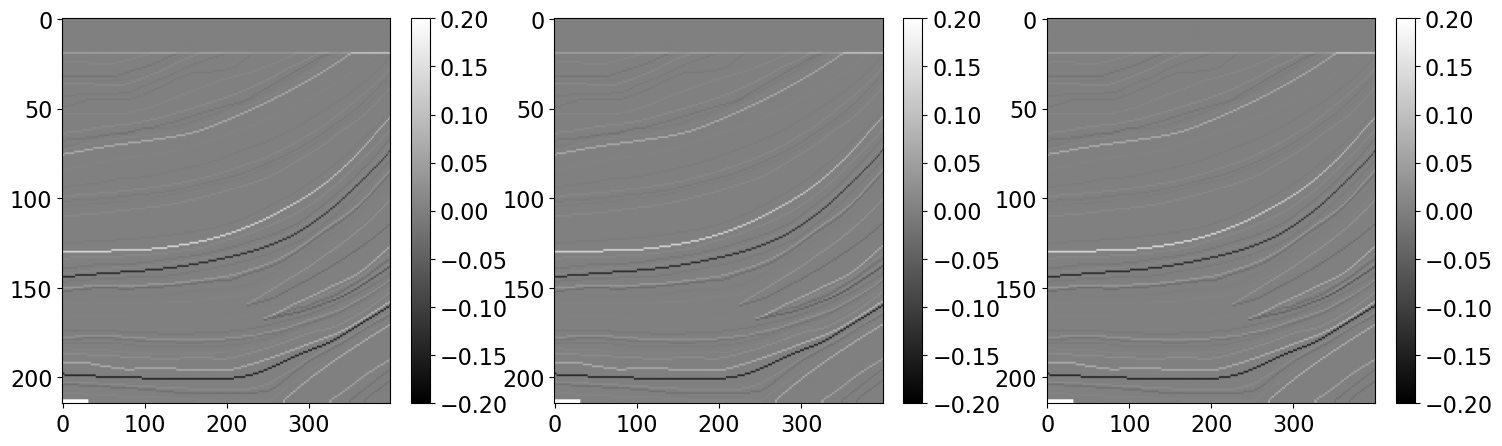

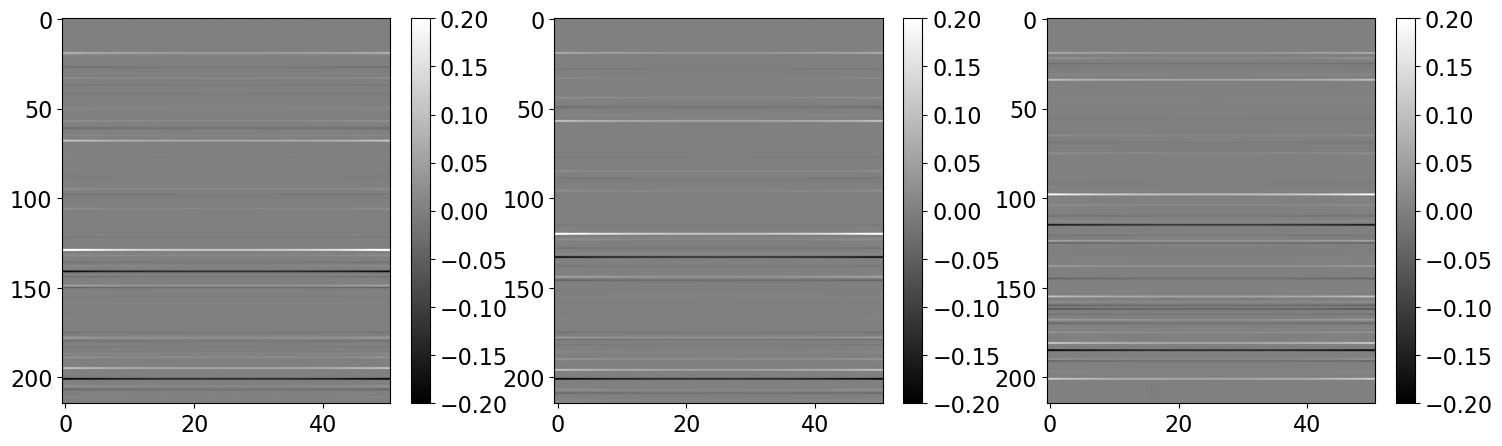

In [8]:
# Compute full angle and averaged reflectivity
nthetas = 51
thetas0 = np.linspace(-40, 40, nthetas)

refls, refl_av = refl_angle(thetas0, vel_true)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))   
im = axs[0].imshow(refls[20].T, cmap='gray', vmin=-0.2, vmax=0.2)
axs[0].axis('tight')
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(refls[nthetas//2].T, cmap='gray', vmin=-0.2, vmax=0.2)
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1])
im = axs[2].imshow(refls[-20].T, cmap='gray', vmin=-0.2, vmax=0.2)
axs[2].axis('tight')
plt.colorbar(im, ax=axs[2])

fig, axs = plt.subplots(1, 3, figsize=(18, 5))   
im = axs[0].imshow(refls[:, nx//4].T, cmap='gray', vmin=-0.2, vmax=0.2)
axs[0].axis('tight')
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(refls[:, nx//2].T, cmap='gray', vmin=-0.2, vmax=0.2)
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1])
im = axs[2].imshow(refls[:, 3*nx//4].T, cmap='gray', vmin=-0.2, vmax=0.2)
axs[2].axis('tight')
plt.colorbar(im, ax=axs[2]);

#print(thetas0[40], thetas1[40,0,0])

In [9]:
# Kirchhoff modelling
nt = 601
dt = 0.004
f0 = 15
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=f0)

kop = Kirchhoff(z, x, t, sources, recs, vel_true, wav, wavc, mode='eikonal', 
                dynamic=True, wavfilter=False, aperture=None, angleaperture=200, engine='numba')
kop.angle_recs = kop.angle_srcs.copy() # done as a quick and dirty way to remove the cos(theta) weighting term in modelling

d = kop * refl_av.ravel()
d = d.reshape(ns, nr, nt)

In [10]:
# Comparison with FD
tn = 4000 # Total simulation time

v0_ = v0 * np.ones((nx, nz))
v0_[-1, -1] = vel_true.max()
d_fd, u_fd, dt_fd = fdmodelling(vel_true, dx, dz, dt, sx, sz, rx, rz, tn, f0, v0, 0, nt)
d0_fd, u0_fd, dt0_fd = fdmodelling(v0_, dx, dz, dt, sx, sz, rx, rz, tn, f0, v0, 0, nt)
d0_fd[:, 251:] = 0
d_fd = d_fd - d0_fd

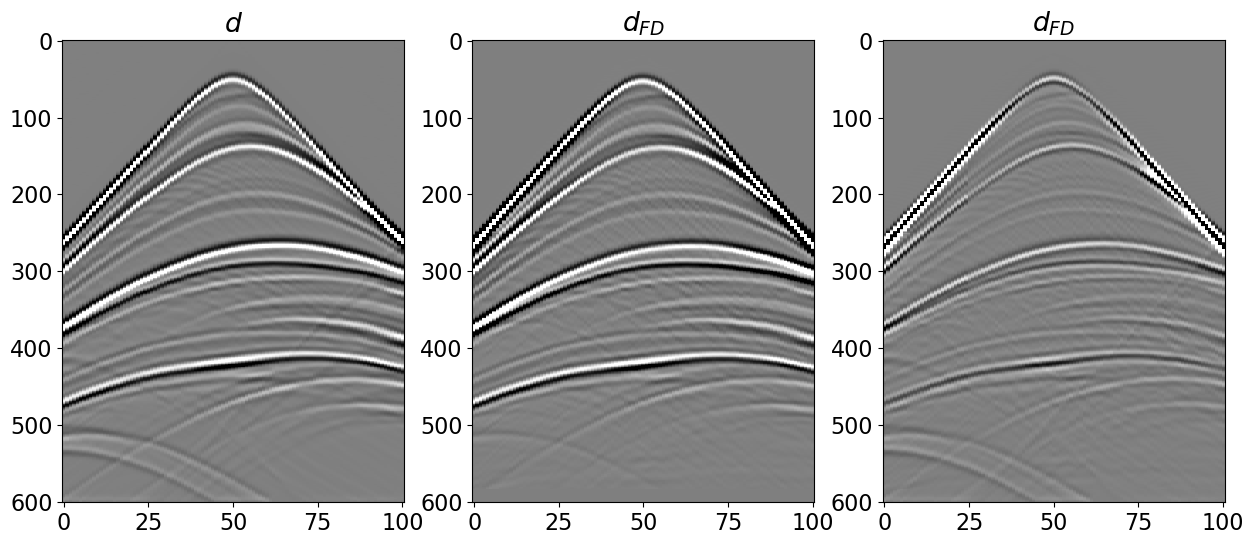

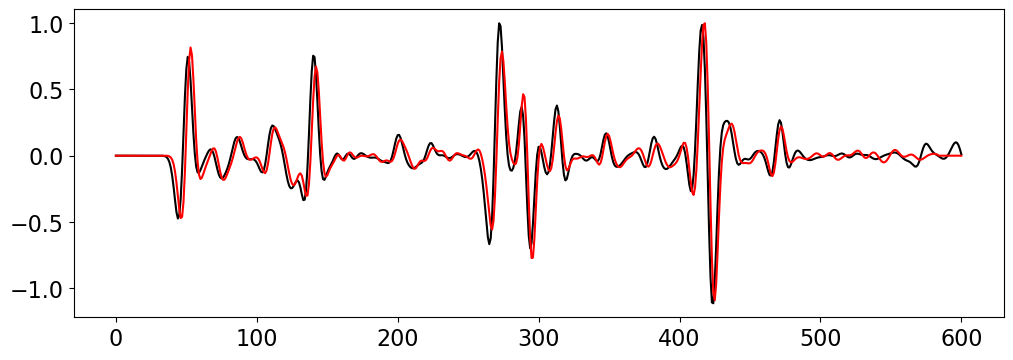

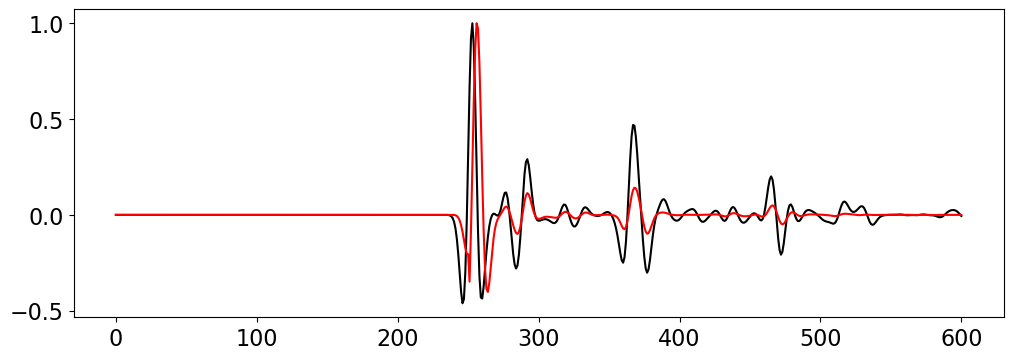

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d[ns//2, :, :].T / np.max(d[ns//2, nr//2, :].T), cmap='gray', interpolation='none', vmin=-8e-1, vmax=8e-1)
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(d_fd[:, :nt].T / np.max(d_fd[nr//2, :nt].T), cmap='gray', interpolation='none', vmin=-8e-1, vmax=8e-1)
axs[1].set_title(r'$d_{FD}$')
axs[1].axis('tight')
axs[2].imshow(d[ns//2, :, :].T / np.max(d[ns//2, nr//2, :].T) - d_fd[:, :nt].T / np.max(d_fd[nr//2, :nt].T), 
              cmap='gray', interpolation='none', vmin=-8e-1, vmax=8e-1)
axs[2].set_title(r'$d_{FD}$')
axs[2].axis('tight')

plt.figure(figsize=(12, 4))
plt.plot(d[0, nr//2, :].T / np.max(d[0, nr//2, :].T), 'k')
plt.plot(d_fd[nr//2, :nt].T / np.max(d_fd[nr//2, :nt].T), 'r');

plt.figure(figsize=(12, 4))
plt.plot(d[0, 2, :].T / np.max(d[0, 2, :].T), 'k')
plt.plot(d_fd[2, :nt].T / np.max(d_fd[2, :nt].T), 'r');